In [21]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3

In [22]:
def area(x):
    ref = [358.758 , 353.286,366.966 ,372.096 , 363.546 , 371.754 , 353.97 , 345.42 , 578]
    done = []
    ar = 0
    for i in range(len(x)):
        if (x[i] not in done) :
            ar += ref[int(x[i])]
            done.append(x[i]) 
    
    return ar

def power(x):
    z = np.load('powerTable3l.npy')
    return z[int(np.floor(x[0]))][int(np.floor(x[1]))][int(np.floor(x[2]))]

def delay(x):
    z = np.load('delayTable3l.npy')
    return z[int(np.floor(x[0]))][int(np.floor(x[1]))][int(np.floor(x[2]))]

def errorAcc(x):
    z = np.load('tmp3l.npy')
    # z = combineBatches()
    return z[int(np.floor(x[0]))][int(np.floor(x[1]))][int(np.floor(x[2]))]

def pdp(x):
    return power(x)*delay(x)

def combinedFunc(x):
    return np.array([ pdp(x), area(x), errorAcc(x) ])

In [23]:
!pip3 install pandas

In [24]:
class MyProblem(Problem):
    def __init__(self):
        super().__init__(n_var=3 ,  n_obj = 3 , xl = 0 , xu = 8 , vtype=int)

    def _evaluate(self, designs, out, *args, **kwargs):
        # out["F"] = np.column_stack([])
        res = []
        for design in designs:
            res.append(combinedFunc(design))

        out["F"] = np.array(res)

problem = MyProblem()
# ref_points = np.array([[0,0,0] , [100, 0, 0]])

In [25]:
import pandas as pd

In [26]:
def generate_permutations(arrays, n):
    def backtrack(curr_permutation, index):
        if len(curr_permutation) == n:
            permutations.append(curr_permutation[:])
            return

        current_array = arrays[index]
        for element in current_array:
            curr_permutation.append(element)
            backtrack(curr_permutation, index + 1)
            curr_permutation.pop()

    permutations = []
    backtrack([], 0)
    return permutations

def genRefPoints(problem , k=2):
    sl = pd.read_csv("randomSensTest_l3.csv").to_numpy().T[1:].T
    rpIdx = []
    for layer in sl:
        l = np.argsort(layer)
        bestIdx = []
        for i in range(k):
            bestIdx.append(l[-1-i])
        rpIdx.append(bestIdx)
    ptsX = generate_permutations(rpIdx , problem.n_var)
    ptsF = []

    for x in ptsX:
        ptsF.append(combinedFunc(x))
    return np.array(ptsF)
        
# ref_points = genRefPoints(problem , 2)
# genRefPoints(problem , 2)
# np.array([[0,0,0] , [100, 0, 0]])




In [27]:
algorithm = RNSGA2(
    ref_points=genRefPoints(problem , k=2),
    pop_size=100,
    epsilon=0.01,
    normalization='front',
    extreme_points_as_reference_points=False, sampling=IntegerRandomSampling() , crossover=SBX(eta = 1,vtype=float, repair=RoundingRepair()) , mutation=PolynomialMutation(eta = 5,vtype=float, repair=RoundingRepair()))
# algorithm = NSGA3(
#                   ref_dirs=genRefPoints(problem , k=2),
#                   pop_size=100,
#                   epsilon=0.01,
#                   normalization='front',
#                   extreme_points_as_reference_points=False, sampling=IntegerRandomSampling() , crossover=SBX(eta = 1,vtype=float, repair=RoundingRepair()) , mutation=PolynomialMutation(eta = 5,vtype=float, repair=RoundingRepair())
#                   )

In [28]:
stop_criteria = ('n_gen' , 1000)
results = minimize(problem=problem , algorithm=algorithm, termination=stop_criteria , verbose=True , save_history = True )
print(results.X)
print(results.F)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |     15 |             - |             -
     2 |      191 |     16 |  0.0357142857 |         ideal
     3 |      291 |     24 |  0.1250117345 |         ideal
     4 |      391 |     19 |  0.0115794349 |         nadir
     5 |      491 |     21 |  0.0068919560 |         ideal
     6 |      591 |     24 |  0.0105808141 |             f
     7 |      691 |     24 |  0.0065324607 |             f
     8 |      791 |     24 |  0.0007376026 |             f
     9 |      891 |     24 |  0.0007376026 |             f
    10 |      991 |     24 |  0.0007376026 |             f
    11 |     1091 |     24 |  0.0007376026 |             f
    12 |     1191 |     24 |  0.0007376026 |             f
    13 |     1291 |     24 |  0.0007376026 |             f
    14 |     1391 |     24 |  0.0007376026 |             f
    15 |     1491 |     24 |  0.0007376026 |             f
    16 |     1591 |     24 |  0.0007376026 |            

0.00023806095123291016


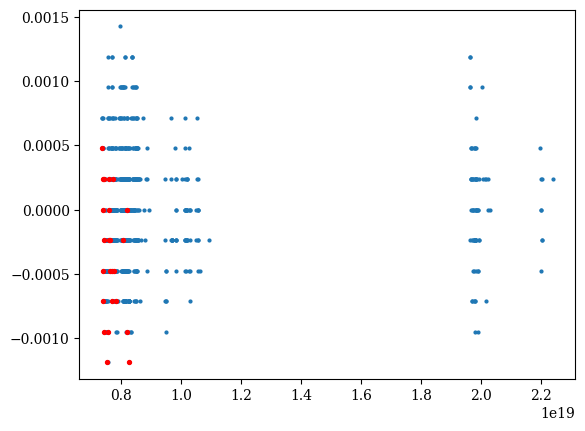

In [29]:
import matplotlib.pyplot as plt
import scipy.io

pdp_all = []
erracc_all = []
area_all = []

for i in range(0, 9):
    for j in range(0, 9):
        for k in range(0, 9):
            pdp_all.append(pdp([i, j, k]))
            erracc_all.append(errorAcc([i, j, k]))
            area_all.append(area([i, j, k]))


print(errorAcc([8,8,8]))

plt.scatter(pdp_all, erracc_all, s=4)
plt.scatter(results.F[:, 0], results.F[:, 2], s=8, color='red')

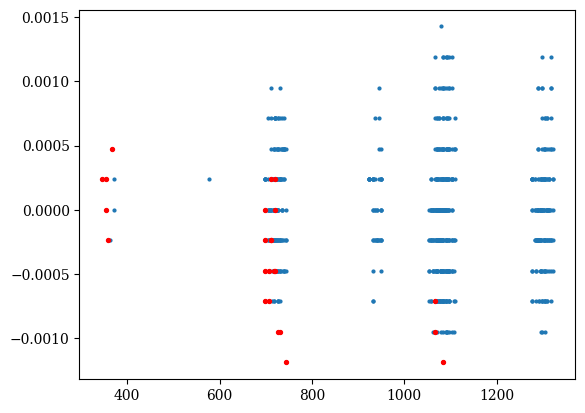

In [30]:
plt.scatter(area_all, erracc_all, s=4)
plt.scatter(results.F[:, 1], results.F[:, 2], s=8, color='red')

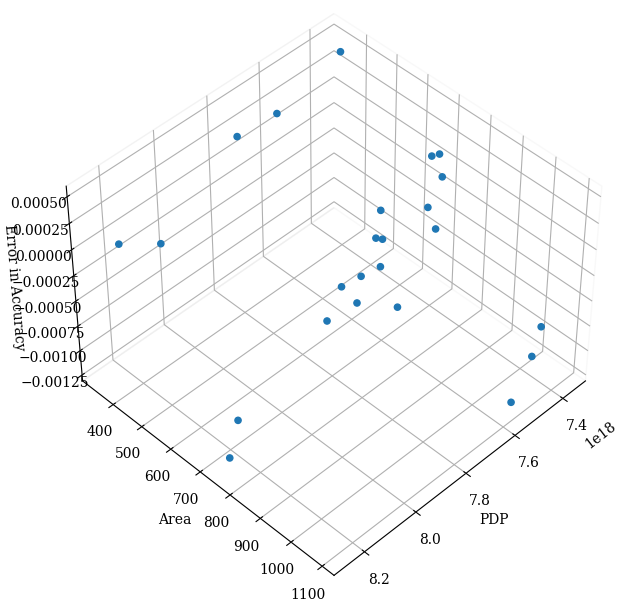

In [31]:
Scatter(tight_layout = True, labels = ['PDP', 'Area', 'Error in Accuracy']).add(results.F).show()

In [32]:
results.F

array([[ 7.71011502e+18,  7.07256000e+02, -7.14302063e-04],
       [ 7.81965023e+18,  6.99390000e+02, -7.14302063e-04],
       [ 7.75041839e+18,  3.45420000e+02,  2.38060951e-04],
       [ 7.76245972e+18,  6.99390000e+02, -4.76181507e-04],
       [ 7.69452086e+18,  7.07256000e+02, -4.76181507e-04],
       [ 8.25205988e+18,  7.43850000e+02, -1.19048357e-03],
       [ 7.39002777e+18,  7.20936000e+02,  0.00000000e+00],
       [ 8.21040193e+18,  3.53970000e+02,  0.00000000e+00],
       [ 7.54922069e+18,  1.08379800e+03, -1.19048357e-03],
       [ 7.62634109e+18,  6.98706000e+02, -2.38120556e-04],
       [ 7.60474543e+18,  3.53286000e+02,  2.38060951e-04],
       [ 7.43440446e+18,  7.12386000e+02, -2.38120556e-04],
       [ 7.41324395e+18,  1.06567200e+03, -7.14302063e-04],
       [ 7.44631317e+18,  1.06635600e+03, -9.52363014e-04],
       [ 7.57358983e+18,  7.30512000e+02, -9.52363014e-04],
       [ 7.36839462e+18,  3.66966000e+02,  4.76181507e-04],
       [ 7.40347960e+18,  7.20252000e+02

In [33]:
pdp_all = np.array(pdp_all)
area_all = np.array(area_all)
erracc_all = np.array(erracc_all)

pdp_all = pdp_all.reshape(pdp_all.shape[0], 1)
area_all = area_all.reshape(pdp_all.shape[0], 1)
erracc_all = erracc_all.reshape(pdp_all.shape[0], 1)

all_f = np.append(pdp_all, area_all, axis=1)
all_f = np.append(all_f, erracc_all, axis=1)
# [pdp_all, area_all, erracc_all]
all_f.shape

(729, 3)

In [34]:
np.save('all_f_l3.npy', all_f)

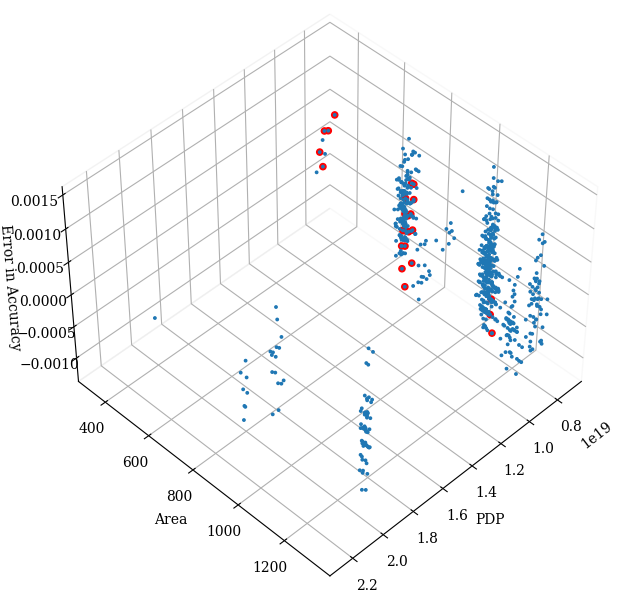

In [35]:
plot = Scatter(tight_layout = True, labels = ['PDP', 'Area', 'Error in Accuracy']).add(all_f, s=3)
plot.add(results.F, color='red').show()
# plot.show()

In [36]:
np.save("RNSGA2_l3_PDPvsAREA_X.npy" , results.X)
np.save("RNSGA2_l3_PDPvsAREA_F.npy" , results.F)

In [37]:
results.F

array([[ 7.71011502e+18,  7.07256000e+02, -7.14302063e-04],
       [ 7.81965023e+18,  6.99390000e+02, -7.14302063e-04],
       [ 7.75041839e+18,  3.45420000e+02,  2.38060951e-04],
       [ 7.76245972e+18,  6.99390000e+02, -4.76181507e-04],
       [ 7.69452086e+18,  7.07256000e+02, -4.76181507e-04],
       [ 8.25205988e+18,  7.43850000e+02, -1.19048357e-03],
       [ 7.39002777e+18,  7.20936000e+02,  0.00000000e+00],
       [ 8.21040193e+18,  3.53970000e+02,  0.00000000e+00],
       [ 7.54922069e+18,  1.08379800e+03, -1.19048357e-03],
       [ 7.62634109e+18,  6.98706000e+02, -2.38120556e-04],
       [ 7.60474543e+18,  3.53286000e+02,  2.38060951e-04],
       [ 7.43440446e+18,  7.12386000e+02, -2.38120556e-04],
       [ 7.41324395e+18,  1.06567200e+03, -7.14302063e-04],
       [ 7.44631317e+18,  1.06635600e+03, -9.52363014e-04],
       [ 7.57358983e+18,  7.30512000e+02, -9.52363014e-04],
       [ 7.36839462e+18,  3.66966000e+02,  4.76181507e-04],
       [ 7.40347960e+18,  7.20252000e+02